# Tolerance solver

In [13]:
import sympy
import math
import numpy as np
import matplotlib.pyplot as plt

**Goal:** 
> Define a method for solving mathematical equations within `ato` code and assign tolerances to the components according to a tolerance required on the output value of the equation.

## Assumptions

In this first step, we are going to assume that the tolerance of the input variables follows a gaussian distribution and that there is no covariance between the input values variances.

For the record, if there was covariance, the equation would look like this:

$$
\sigma_F^2 \approx \sum_{i=1}^{n} \left( \frac{\partial F}{\partial x_i} \right)^2 \sigma_{x_i}^2 + 2\sum_{i=1}^{n-1}\sum_{j=i+1}^{n} \left( \frac{\partial F}{\partial x_i} \frac{\partial F}{\partial x_j} \right) \text{Cov}(x_i, x_j)
$$

Where:
- $ F(x_1, x_2, ..., x_n) $ is the output function.
- $ \sigma_F $ is the uncertainty in the output.
- $ \frac{\partial F}{\partial x_i} $ is the partial derivative of $ F $ with respect to the variable $ x_i $.
- $ \sigma_{x_i} $ is the uncertainty in the variable $ x_i $.
- $ \text{Cov}(x_i, x_j) $ is the covariance between variables $ x_i $ and $ x_j $.

In our case, since there is no co-variance, we can simplify to:

$$
\sigma_F^2 \approx \sum_{i=1}^{n} \left( \frac{\partial F}{\partial x_i} \right)^2 \sigma_{x_i}^2
$$

## Applying to a voltage divider

But first, let's start by solving a simple voltage divider.

$$
V_{\text{out}} = V_{\text{in}} \times \frac{R_2}{R_1 + R_2}
$$
$$
R_{\text{total}} = R_1 + R_2
$$

Say that the user is asking for the following requirements:
- $ V_{\text{in}} = 5V \pm 10\% $
- $ V_{\text{out}} = 1.22V $
- $ R_{\text{total}} = 10kΩ \pm 10\% $

We'd like to figure out the required value for $R_1$ and $R_2$

In [24]:
vin_percent_tolerance = 0.1
Rtotal_percent_tolerance = 0.1
Rtotal = 100000
V_in = 5
V_out = 1.22

R1, R2, Vin, Vout, Rtot = sympy.symbols('R1 R2 Vin Vout Rtot')

equation1 = sympy.Eq(Vin, Vout * (R1 + R2) / R2)
equation2 = sympy.Eq(Rtot, R1 + R2)

substitutes = {Vin: 5, Vout: 1.22, Rtot: Rtotal}
eq1_sub = equation1.subs(substitutes)
eq2_sub = equation2.subs(substitutes)
solutions = sympy.solve((eq1_sub, eq2_sub), (R1, R2))

for solution in solutions:
    print(f"solution for {solution} = {solutions[solution]:.0f} Ω")

solution for R1 = 75600 Ω
solution for R2 = 24400 Ω


## Finding the tolerance values

To find the values of sigma that solve for the equation above, we first need to find the partial derivatives of all the input variables. This will tell us how much the tolerance of each input variable impacts the output variable tolerence. Just as a reminder, here is the equation.

$$
\sigma_F^2 \approx \sum_{i=1}^{n} \left( \frac{\partial F}{\partial x_i} \right)^2 \sigma_{x_i}^2
$$

## Dealing with elasticity

because we are dealing with tolerance in % rather than just a value, we need to scale the partial derivative accordingly. There is some additional documentation ([here](https://en.wikipedia.org/wiki/Output_elasticity) and [here](https://en.wikipedia.org/wiki/Elasticity_of_a_function)).

Just for the record, in math they say:
$$
Ef(a) = \frac{a}{f(a)}f'(a)
$$
and in economics they say:
$$
E_Q = \frac{\partial Q}{\partial \textbf{x}} \cdot \frac{\textbf{x}}{Q}
$$
where $\textbf{x}$ represents the inputs and $Q$, the output.

So if we inject this back in the equation above, we get:

$$
\frac{\sigma_F^2}{F(x_1, x_2, ..., x_n)} \approx \sum_{i=1}^{n} \left( \frac{\partial F}{\partial x_i} \frac{x_i}{F(x_1, x_2, ..., x_n)} \right)^2 \frac{\sigma_{x_i}}{x_i}^2
$$

## Cost function

We also have the cost function for our different input values. Those look like this:

$$
Cost = C(\sigma_{x_i})
$$
And the total cost is:
$$
\text{Total Cost} = \sum_{i=1}^{n} C(\sigma_{x_i})
$$

Now we'd like to find the tolerance value to apply to the components so that the cost is the lowest. To be able to answer that, we need to understand what the cost of a tighther tolerance is. Here are some example of equations that we could use to evalutate this:

1. Linear Tolerance Cost Function:
   $$ \text{cost} = C(\sigma_{x_i}) = -a\sigma_{x_i} + b $$

2. Reciprocal Tolerance Cost Function:
   $$ \text{cost} = C(\sigma_{x_i}) = \frac{1}{\sigma_{x_i} \cdot a} $$

3. Exponential Tolerance Cost Function:
   $$ \text{cost} = C(\sigma_{x_i}) = b + e^{-k \sigma_{x_i}} $$

4. Logarithmic Tolerance Cost Function:
   $$ \text{cost} = C(\sigma_{x_i}) = \log\left(\frac{b}{\sigma_{x_i}}\right) + k $$


(0.0, 10.0)

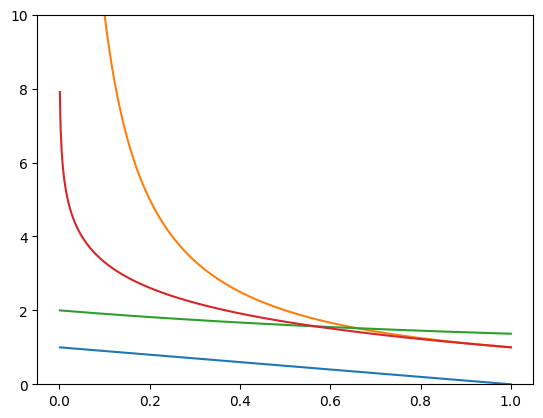

In [15]:
def tolerance_cost_function_lin(x, a, b):
    return -a*x + b

def tolerance_cost_function_rec(x, a):
    return 1/(x * a)

def tolerance_cost_function_exp(x, k, b):
    return b + math.e**(-k * x)

def tolerance_cost_function_log(x, b, k):
    return math.log(b/x) + k

lin = []
rec = []
exp = []
log = []
x = np.linspace(0, 1, 1000)
x = x[x != 0]
for tolerance  in x:
    lin.append(tolerance_cost_function_lin(tolerance, 1, 1))
    rec.append(tolerance_cost_function_rec(tolerance, 1))
    exp.append(tolerance_cost_function_exp(tolerance, 1, 1))
    log.append(tolerance_cost_function_log(tolerance, 1, 1))

plt.plot(x, lin, label="linear")
plt.plot(x, rec, label="reciprocal")
plt.plot(x, exp, label="exponential")
plt.plot(x, log, label="logarithmic")
plt.ylim(0,10)

## Finding the cheapest set of tolerances

We can solve this using the lagrangian multiplier.

Our constraint is:
$$
g(x_1, x_2, ..., x_n) = 0 = \sum_{i=1}^{n} \left(\left( \frac{\partial F}{\partial x_i} \frac{x_i}{F(x_1, ..., x_n)} \right)^2 \frac{\sigma_{x_i}}{x_i}^2\right) - \frac{\sigma_F^2}{F(x_1, ..., x_n)}
$$

and our objective function that we want to minimize is:
$$
f(x_1, x_2, ..., x_n) = \text{Total Cost} = \sum_{i=1}^{n} C(\sigma_{x_i})
$$
Our Lagragina becomes:
$$
\mathcal{L}(x_1, x_2, ..., x_n, \lambda) = f(x_1, x_2, ..., x_n) - \lambda \cdot g(x_1, x_2, ..., x_n)
$$

With, $\lambda$ is the Lagrangian multiplier.

Grant Sanderson has an awesome video about it [here](https://www.youtube.com/watch?v=yuqB-d5MjZA).


To find the optimal points, we solve the system of equations formed by taking the partial derivatives of $ \mathcal{L} $ with respect to each variable $ x_i $ and the multiplier $ \lambda $, and setting them equal to zero:

$$
\frac{\partial \mathcal{L}}{\partial x_1} = 0, \quad \frac{\partial \mathcal{L}}{\partial x_2} = 0, \quad ..., \quad \frac{\partial \mathcal{L}}{\partial x_n} = 0, \quad \frac{\partial \mathcal{L}}{\partial \lambda} = 0
$$

Solving this system of equations yields the values of $ x_1, x_2, ..., x_n $ and $ \lambda $ that optimize the original function subject to the constraint.

## Applying the lagrangian to the voltage divider example

In [23]:
# partial derivatives
pd_r1_eq1 = sympy.diff(equation1.rhs, R1)
pd_r2_eq1 = sympy.diff(equation1.rhs, R2)

pd_r1_eq2 = sympy.diff(equation2.rhs, R1)
pd_r2_eq2 = sympy.diff(equation2.rhs, R2)

# Partial derivatives evaluated at the soltion
num_pd_r1_eq1 = abs(pd_r1_eq1.subs({Vout: V_out, R1: solutions[R1], R2: solutions[R2]}))
num_pd_r2_eq1 = abs(pd_r2_eq1.subs({Vout: V_out, R1: solutions[R1], R2: solutions[R2]}))

num_pd_r1_eq2 = abs(pd_r1_eq2.subs({Rtot: Rtotal, R1: solutions[R1], R2: solutions[R2]}))
num_pd_r2_eq2 = abs(pd_r2_eq2.subs({Rtot: Rtotal, R1: solutions[R1], R2: solutions[R2]}))

# Elasticitcity at the solution since we deal with tolerances in %
rel_num_pd_r1_eq1 = num_pd_r1_eq1 * solutions[R1]/V_in
rel_num_pd_r2_eq1 = num_pd_r2_eq1 * solutions[R2]/V_in

rel_num_pd_r1_eq2 = num_pd_r1_eq2 * solutions[R1]/Rtotal
rel_num_pd_r2_eq2 = num_pd_r2_eq2 * solutions[R2]/Rtotal

# Solving with lagrangian
# Define the symbols
sigma_x1_sq = sympy.symbols('sigma_x1_sq', positive=True)
sigma_x2_sq = sympy.symbols('sigma_x2_sq', positive=True)
lambda_ = sympy.symbols('lambda_')  # Lagrange multiplier
k1, k2, sigma_y_sq = sympy.symbols('k1 k2 sigma_y_sq')  # constants

# Objective function (total cost)
total_cost = tolerance_cost_function_rec(sympy.sqrt(sigma_x1_sq), 1) + tolerance_cost_function_rec(sympy.sqrt(sigma_x2_sq), 1)

constraint = (rel_num_pd_r1_eq1**2 * sigma_x1_sq + rel_num_pd_r2_eq1**2 * sigma_x2_sq) - vin_percent_tolerance**2

# Lagrangian
L = lambda_ * constraint - total_cost

# Equation system
eq1 = sympy.diff(L, sigma_x1_sq)
eq2 = sympy.diff(L, sigma_x2_sq)
eq3 = sympy.diff(L, lambda_) # here is seem that total cost disapears since it's not a function of lambda

solution = sympy.solve((eq1, eq2, eq3), (sigma_x1_sq, sigma_x2_sq, lambda_))

equation_outline = equation1.subs({Vout: 1.22})
for sol in solution:
    print(f"tolerance on R1 = {math.sqrt(sol[0])* 100:.1f}%")
    print(f"tolerance on R2 = {math.sqrt(sol[1])* 100:.1f}%")

tolerance on R1 = 9.4%
tolerance on R2 = 9.4%


## Another example: An RC Filter

In [32]:
def print_outline(symbol_1, value_1, tolerance_1, symbol_2, value_2, tolerance_2, equation, symbol_output, value_output, tolerance_output):
    print("allowed values for", symbol_output, "are between", value_output * (1 - tolerance_output), "and", value_output * (1 + tolerance_output))
    options = [[1,1], [-1,-1], [-1, 1], [1,-1]]
    outline_values = []
    for option in options:
        subbed_equation = equation.subs({symbol_1: (value_1 + value_1 * tolerance_1 * option[0]), symbol_2: (value_2 + value_2 * tolerance_2 * option[1])})
        outline_values.append(sympy.solve(subbed_equation)[0])
    print("Minimum value:", min(outline_values))
    print("Maximum value:", max(outline_values))

R, C, FC = sympy.symbols('R C fc')
fc = 10  # Cutoff frequency in Hz
fc_tolerance = 0.1
R_value = 1000

cutoff_equration = sympy.Eq(FC, 1 / (2 * sympy.pi * R * C))
cutoff_eq = cutoff_equration.subs(FC, fc)

# Solve the equation for C
solution_for_C = sympy.solve(cutoff_eq.subs(R, R_value), C)

pd_r = sympy.diff(cutoff_eq.rhs, R)
pd_c = sympy.diff(cutoff_eq.rhs, C)

num_pd_r = abs(pd_r.subs({R: R_value, C: solution_for_C[0]}))
num_pd_c = abs(pd_c.subs({R: R_value, C: solution_for_C[0]}))

# Finding the relative partial derivative, since we are dealing with tolerances in %. See elasticity comment above.
rel_num_pd_r = num_pd_r * R_value/fc
rel_num_pd_c = num_pd_c * solution_for_C[0]/fc

# Solving with lagrangian
constraint = (rel_num_pd_r**2 * sigma_x1_sq + rel_num_pd_c**2 * sigma_x2_sq) - fc_tolerance**2
total_cost = tolerance_cost_function_rec(sympy.sqrt(sigma_x1_sq), 1) + tolerance_cost_function_rec(sympy.sqrt(sigma_x2_sq), 1)

L = lambda_ * constraint - total_cost

# System of equations from the partial derivatives of L
eq1 = sympy.diff(L, sigma_x1_sq)
eq2 = sympy.diff(L, sigma_x2_sq)
eq3 = sympy.diff(L, lambda_) # here is seem that total cost disapears since it's not a function of lambda

# Solve the system of equations
solution = sympy.solve((eq1, eq2, eq3), (sigma_x1_sq, sigma_x2_sq, lambda_))

print(f"tolerance required at the output: {fc_tolerance * 100}%")
for sol in solution:
    print(f"tolerance on R = {math.sqrt(sol[0])* 100:.1f}%")
    print(f"tolerance on C = {math.sqrt(sol[1])* 100:.1f}%")
    print_outline(C, solution_for_C[0], math.sqrt(sol[0]), R, R_value, math.sqrt(sol[1]), cutoff_equration, FC, fc, fc_tolerance)


tolerance required at the output: 10.0%
tolerance on R = 7.1%
tolerance on C = 7.1%
allowed values for fc are between 9.0 and 11.0
Minimum value: 8.72279633102892
Maximum value: 11.5797212821627


## Another example: Butterworth LC Filter

In [31]:
L, C, FC = sympy.symbols('L C fc', positive=True)
fc = 1000
fc_tolerance = 0.02
omega_c = 2 * sympy.pi * fc
L_value = 10e-3  # 10 mH

# Equation for LC filter cutoff frequency
equation_lc = sympy.Eq(FC, 1/(sympy.sqrt(L*C) * 2 *sympy.pi))
eq_lc = equation_lc.subs(FC, fc)

solution_for_C = sympy.solve(eq_lc.subs(L, L_value), C)

pd_l = sympy.diff(eq_lc.rhs, L)
pd_c = sympy.diff(eq_lc.rhs, C)

num_pd_l = abs(pd_l.subs({L: L_value, C: solution_for_C[0]}))
num_pd_c = abs(pd_c.subs({L: L_value, C: solution_for_C[0]}))

# Finding the relative partial derivative, since we are dealing with tolerances in %. See elasticity comment above.
rel_num_pd_l = num_pd_l * L_value/fc
rel_num_pd_c = num_pd_c * solution_for_C[0]/fc

# Solving with lagrangian
constraint = (rel_num_pd_l**2 * sigma_x1_sq + rel_num_pd_c**2 * sigma_x2_sq) - fc_tolerance**2
total_cost = tolerance_cost_function_rec(sympy.sqrt(sigma_x1_sq), 1) + tolerance_cost_function_rec(sympy.sqrt(sigma_x2_sq), 10)

La = lambda_ * constraint - total_cost

# System of equations from the partial derivatives of L
eq1 = sympy.diff(La, sigma_x1_sq)
eq2 = sympy.diff(La, sigma_x2_sq)
eq3 = sympy.diff(La, lambda_) # here is seem that total cost disapears since it's not a function of lambda

# Solve the system of equations
solution = sympy.solve((eq1, eq2, eq3), (sigma_x1_sq, sigma_x2_sq, lambda_))

print(f"tolerance required at the output: {fc_tolerance * 100}%")
for sol in solution:
    print(f"tolerance on L = {math.sqrt(sol[0])* 100:.1f}%")
    print(f"tolerance on C = {math.sqrt(sol[1])* 100:.1f}%")
    print_outline(C, solution_for_C[0], math.sqrt(sol[0]), L, L_value, math.sqrt(sol[1]), equation_lc, FC, fc, fc_tolerance)

tolerance required at the output: 2.0%
tolerance on L = 3.6%
tolerance on C = 1.7%
allowed values for fc are between 980.0 and 1020.0
Minimum value: 974.169537671914
Maximum value: 1027.33737348737


## Actually looking for components

Say we had found tolerance requirements for all components and our goal is to select components, there could be several stragies we apply:

1) **Dumb:** Only select components that fall within the bounds we set
2) **Less dumb:** For components slightly outside the tolerance band, evaluate the cost impact to other components and decide whether the cost down is worth it (ie. the cost up on all the other components is less than the cost down)

-> Let's evaluate the less dumb approach below:

We have:
$$
\Delta \text{\$}_{\text{selection}} = \$_{\text{selected component}} - C(\sigma_{x_i})
$$
$$
\Delta \sigma_{\text{selection}} = \sigma_{\text{selected component}} - \sigma_{x_i}
$$

where $C(\sigma_{x_i})$ was the solution found above and $\sigma_{\text{selected component}} > \sigma_{x_i}$

We also know that:

$$
\sigma_F^2 = \left(\frac{\partial F}{\partial x_m} \frac{x_m}{F(x_1, x_2, ..., x_n)}\right)^2 (\sigma_{x_m} + \Delta \sigma_{\text{selection}})^2 + \sum_{\substack{i=1 \\ i \neq m}}^{n} \left( \frac{\partial F}{\partial x_i} \frac{x_i}{F(x_1, x_2, ..., x_n)} \right)^2 (\sigma_{x_i} + \Delta \sigma_{x_i})^2
$$

To simplify let's use the following notation for the elasticity of the function:
$$
\frac{\partial F}{\partial x_m} \cdot \frac{x_n}{F(x_1, x_2, ..., x_n)} = E_{F_n}
$$


Cleaned up we have:

$$
\sigma_F^2 = E_{F_m}^2 (\sigma_{x_m} + \Delta \sigma_{\text{selection}})^2 + \sum_{\substack{i=1 \\ i \neq m}}^{n} E_{F_i}^2 (\sigma_{x_i} + \Delta \sigma_{x_i})^2
$$

Yielding:

$$
\sigma_F^2 = E_{F_m}^2 \sigma_{x_m}^2 + E_{F_m}^2 * 2\sigma_{x_m} \Delta \sigma_{\text{selection}} + E_{F_m}^2 \Delta \sigma_{\text{selection}}^2 + \sum_{\substack{i=1 \\ i \neq m}}^{n} \left(E_{F_i}^2\sigma_{x_i}^2 + E_{F_i}^2 \cdot 2\sigma_{x_i}\Delta \sigma_{x_i} + E_{F_i}^2\Delta \sigma_{x_i}^2\right)
$$

Yielding again:

$$
\sigma_F^2 = \sum_{\substack{i=1}}^{n} E_{F_i}^2 \sigma_{x_i}^2 + E_{F_m}^2 * 2\sigma_{x_m} \Delta \sigma_{\text{selection}} + E_{F_m}^2 \Delta \sigma_{\text{selection}}^2 + \sum_{\substack{i=1 \\ i \neq m}}^{n} \left(E_{F_i}^2 \cdot 2\sigma_{x_i}\Delta \sigma_{x_i} + E_{F_i}^2\Delta \sigma_{x_i}^2\right)
$$

Yielding once more by substraction on both sides:
$$
\sum_{\substack{i=1 \\ i \neq m}}^{n} \left(E_{F_i}^2 \cdot 2\sigma_{x_i}\Delta \sigma_{x_i} + E_{F_i}^2\Delta \sigma_{x_i}^2\right) + E_{F_m}^2 * 2\sigma_{x_m} \Delta \sigma_{\text{selection}} + E_{F_m}^2 \Delta \sigma_{\text{selection}}^2 = 0
$$